<a href="https://colab.research.google.com/github/dongjaekim-hail/open-source-AI/blob/main/3_recurrent_neural_network_(pytorch).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RNN 모델의 작동 방식

## RNN

In [ ]:
import torch
from torch import nn

# RNN 정의
rnn = nn.RNN(input_size=10, hidden_size=20, batch_first=True)

# 임의의 입력
x = torch.randn(1, 200, 10)  # 배치 크기: 1, 시퀀스 길이: 200, 입력 차원: 10
# t_1..t_200까지 순차적으로 10차원의 데이터가 들어가도록 만들겠다는 뜻.

# 모델 실행
output, hn = rnn(x)
# output은 모든 time 에서 나오는 모든 h들을 모아놓은 것
# hn은 200번에 해당하는 모든 데이터 포인트들을 다 지나간다음에 나오는 녀석

print(f"RNN output shape: {output.shape}")
print(f"RNN hn shape: {hn.shape}")


RNN output shape: torch.Size([1, 200, 20])
RNN hn shape: torch.Size([1, 1, 20])


## LSTM

In [ ]:
# LSTM 정의
lstm = nn.LSTM(input_size=10, hidden_size=20, batch_first=True)

# 임의의 입력
x = torch.randn(1, 200, 10)  # 배치 크기: 1, 시퀀스 길이: 3, 입력 차원: 10
# t_1..t_200까지 순차적으로 10차원의 데이터가 들어가도록 만들겠다는 뜻.

# 모델 실행
output, (hn, cn) = lstm(x)
# 마찬가지로 output은 모든 time 에서 나오는 모든 h들을 모아놓은 것
# LSTM의 경우는 hidden state 에 더해서 channel state 도 있음에 유의

print(f"LSTM output shape: {output.shape}")
print(f"LSTM hn shape: {hn.shape}")
print(f"LSTM cn shape: {cn.shape}")


LSTM output shape: torch.Size([1, 200, 20])
LSTM hn shape: torch.Size([1, 1, 20])
LSTM cn shape: torch.Size([1, 1, 20])


## 일반적인 모델의 형태

In [ ]:
class Model(nn.Module):
    def __init__(self, input_size, hid_size, output_size):
        super(Model, self).__init__()
        self.LSTM = nn.LSTM(input_size = input_size, hidden_size = hid_size, num_layers=2,
                            batch_first=True)
        self.fc1 = nn.Linear(self.hid_size, self.hid_size)
        self.fc2 = nn.Linear(self.hid_size, output_size)

    def forward(self, x):
        """
        input : [bs, maxlen]
        output: [bs, 2]
        """
        x, (h,c) = self.LSTM(x)  # [bs, ml, hid_size]
        x = F.relu(self.fc1(x[:,-1,:]))   # [bs, ml, hid_size]
        # x = F.relu(self.fc1(h))   # [bs, ml, hid_size]
        out = self.fc2(x)
        return out  # [bs, output_size]

# RNN모델을 통한 주가 예측 (regression)

In [ ]:
!pip install yfinance scikit-learn matplotlib

In [ ]:
import torch
import torch.nn as nn
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# 데이터 불러오기
data = yf.download('AAPL', '2000-01-01', '2023-07-01')
data = data['Close'].values

# 데이터 정규화
scaler = MinMaxScaler()
data = scaler.fit_transform(data.reshape(-1, 1)).reshape(-1)

# 설정값 정의
seq_length = 2000
pred_length = 200
hidden_dim = 50
n_features = 1

# 학습 데이터 생성
def create_sequences(data, seq_length, pred_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length-pred_length):
        x = data[i:(i+seq_length)]
        y = data[(i+seq_length):(i+seq_length+pred_length)]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

x, y = create_sequences(data, seq_length, pred_length)
x = torch.tensor(x).float().view(-1, seq_length, n_features)
y = torch.tensor(y).float()

train_x = x[:len(x)//2]
test_x = x[len(x)//2:]
train_y = y[:len(y)//2]
test_y = y[len(y)//2:]

# 모델 정의
class StockPredictor(nn.Module):
    def __init__(self, n_features, hidden_dim, seq_length, pred_length):
        super(StockPredictor, self).__init__()
        self.n_features = n_features
        self.hidden_dim = hidden_dim
        self.seq_len = seq_length
        self.pred_len = pred_length
        self.lstm = nn.LSTM(input_size=n_features, hidden_size=hidden_dim, batch_first=True)
        self.linear = nn.Linear(in_features=hidden_dim*self.seq_len, out_features=pred_length)

    def forward(self, sequences):
        lstm_out, _ = self.lstm(sequences)
        # use all of the hidden states for the linear layer
        x = lstm_out.contiguous().view(-1, self.hidden_dim*self.seq_len)
        y_pred = self.linear(x)
        return y_pred

model = StockPredictor(n_features, hidden_dim, seq_length, pred_length)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# make a data loader from torch
from torch.utils.data import DataLoader, TensorDataset

# batch sampling train loader
train_data = TensorDataset(train_x, train_y)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_data = TensorDataset(test_x, test_y)
test_loader = DataLoader(test_data, batch_size=10000, shuffle=False)

# training
model.train()
for epoch in range(5):  # 50번의 epoch 동안 학습
    model.train()
    # batch sampling
    for batch_idx, (train_x, train_y) in enumerate(train_loader):
        model.zero_grad()

        y_pred = model(train_x)
        loss = criterion(y_pred.float(), train_y)
        print("Epoch ", epoch, "MSE: ", loss.item())
        loss.backward()
        optimizer.step()

    # evaluate for each epoch
    model.eval()
    with torch.no_grad():
        y_pred = model(test_x)
        loss = criterion(y_pred.float(), test_y)
        print("Test Epoch ", epoch, "MSE: ", loss.item())



# 평가
model.eval()
test_preds = model(test_x)


[*********************100%***********************]  1 of 1 completed


Epoch  0 MSE:  0.007943830452859402
Epoch  0 MSE:  20.631275177001953
Epoch  0 MSE:  1.2057366371154785
Epoch  0 MSE:  3.84352445602417
Epoch  0 MSE:  10.443428993225098
Epoch  0 MSE:  8.26391315460205
Epoch  0 MSE:  2.992464542388916
Epoch  0 MSE:  0.0881352350115776
Epoch  0 MSE:  0.992368757724762
Epoch  0 MSE:  3.3855485916137695
Epoch  0 MSE:  4.385980606079102
Epoch  0 MSE:  3.29132080078125
Epoch  0 MSE:  1.4658215045928955
Epoch  0 MSE:  0.21463634073734283
Epoch  0 MSE:  0.07149410992860794
Epoch  0 MSE:  0.7390176653862
Epoch  0 MSE:  1.4702529907226562
Epoch  0 MSE:  1.7499195337295532
Epoch  0 MSE:  1.4177136421203613
Epoch  0 MSE:  0.7958192229270935
Epoch  0 MSE:  0.23272645473480225
Epoch  0 MSE:  0.0079756248742342
Epoch  0 MSE:  0.12222647666931152
Epoch  0 MSE:  0.4184923470020294
Epoch  0 MSE:  0.6808596253395081
Epoch  0 MSE:  0.7435051798820496
Epoch  0 MSE:  0.5802528858184814
Epoch  0 MSE:  0.33921995759010315
Epoch  0 MSE:  0.10043985396623611
Epoch  0 MSE:  0.0

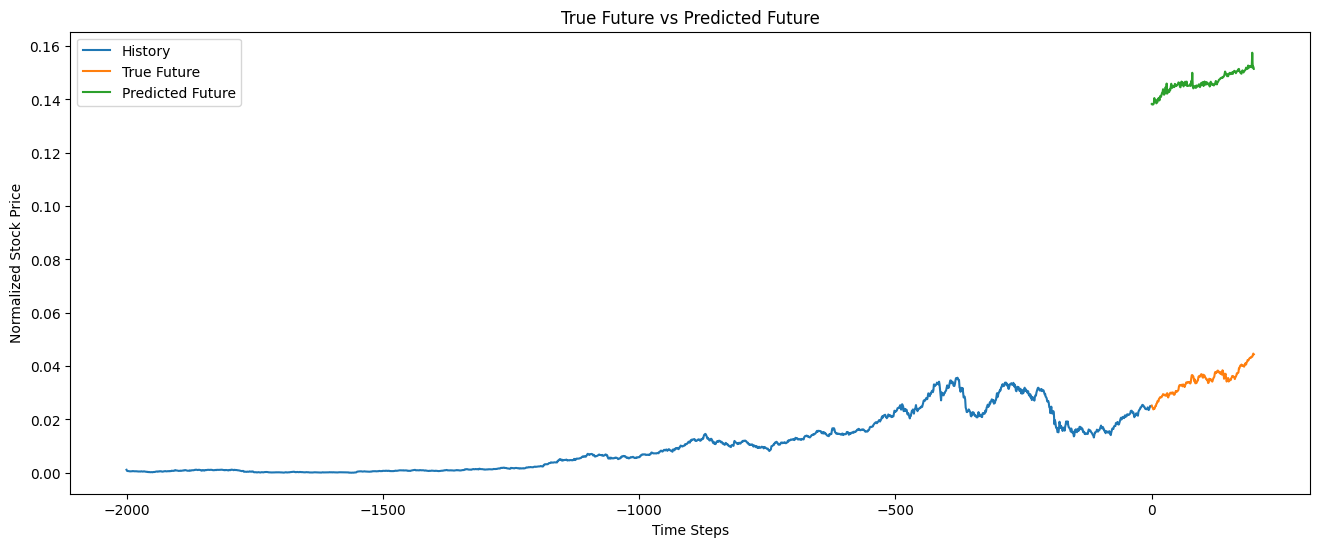

In [ ]:
%matplotlib inline

plt.figure(figsize=(16,6))

range_future = len(test_y)
# plot from -2000 to 0
plt.plot(np.arange(-seq_length, 0, 1), train_x[0,:].numpy(), label='History')


plt.plot(np.arange(200), train_y[0,:].numpy(), label='True Future')
plt.plot(np.arange(200), y_pred[0,:].detach().numpy(), label='Predicted Future')

plt.title('True Future vs Predicted Future')
plt.xlabel('Time Steps')
plt.ylabel('Normalized Stock Price')
plt.legend()


뭘 더해야할까?

이런걸 해결하기  위해서는 보통 regression 에서 시작점이 0 이 되도록 만들어줍니다. 다시 말해서, 초록색 결과물이 0으로부터 시작하도록 만들어주면, 파란색의 마지막 지점으로부터 이어서 연결할 수 있습니다.

예를 들어 파란색이 [0.01, 0.02, ... , 0.07] 으로 구성되어있었다면, regression 의 결과로 나온 초록색은 [0, 0.01, 0.04, ... ] 이런식으로 한 다음, 파란색의 마지막 값인 0.07 을 모두 더해주면 되겠죠!

# RNN을 이용한 문서의 분류 (classification)

### Kaggle 데이터에다가 하고 싶어요

In [ ]:
import os
os.environ["KAGGLE_USERNAME"]="dongjaekim0hail"
os.environ["KAGGLE_KEY"]="0fed299f71948e9e349175761a823223"

In [ ]:
!kaggle competitions download -c osai-project
!unzip osai-project.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: train/39280.png         
  inflating: train/39281.png         
  inflating: train/39285.png         
  inflating: train/39287.png         
  inflating: train/39401.png         
  inflating: train/39416.png         
  inflating: train/39420.png         
  inflating: train/39421.png         
  inflating: train/39427.png         
  inflating: train/39452.png         
  inflating: train/39465.png         
  inflating: train/39470.png         
  inflating: train/39472.png         
  inflating: train/39475.png         
  inflating: train/39482.png         
  inflating: train/39504.png         
  inflating: train/39524.png         
  inflating: train/39526.png         
  inflating: train/39540.png         
  inflating: train/39541.png         
  inflating: train/39542.png         
  inflating: train/39547.png         
  inflating: train/39560.png         
  inflating: train/39562.png         
  inflating: train/39576.png         
  inflating: t

In [ ]:
import pandas as pd # csv 등 테이블 형태의 데이터를 처리하기 좋은 library

train = pd.read_csv('./train/text_label.csv')
test  = pd.read_csv('./test/text_label.csv')
val   = pd.read_csv('./val/text_label.csv')
sol   = pd.read_csv('./solution_sample.csv')

tokenizer는 다양한 library에서 구현되어있습니다. 간단하게 구현되어있는 tokenizer 도 있고, 복잡하게... transformer 등에서 사용하는 tokenizer 도 있습니다. 여기서는 간단한 tokenizer 를 갖다 써봅시다!

파이썬 자연어 처리 라이브러리인 `nltk`를 사용합시다.

In [ ]:
!pip install nltk

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from torch.nn.utils.rnn import pad_sequence
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

nltk.download('punkt_tab')      # 토크나이저 다운로드
nltk.download('stopwords')  # 불용어 다운로드


class CustomTokenizer:
    def __init__(self, lower=True, stemming=True, remove_stopwords=False, stop_words_lang='english'):
        """
        Args:
            lower (bool): Convert text to lowercase.
            stemming (bool): Apply stemming to tokens.
            remove_stopwords (bool): Remove stopwords.
            stop_words_lang (str): Language for stopwords.
        """
        self.lower = lower
        self.stemming = stemming
        self.remove_stopwords = remove_stopwords
        self.stop_words = set(stopwords.words(stop_words_lang)) if remove_stopwords else None
        self.stemmer = PorterStemmer() if stemming else None

    def preprocess(self, text):
        """Preprocess the text based on options."""
        # Lowercase
        if self.lower:
            text = text.lower()

        # Tokenize
        tokens = word_tokenize(text)

        # Remove stopwords
        if self.remove_stopwords:
            tokens = [word for word in tokens if word not in self.stop_words]

        # Apply stemming
        if self.stemming:
            tokens = [self.stemmer.stem(word) for word in tokens]

        return tokens


# 토크나이저 초기화
tokenizer = CustomTokenizer(lower=True, stemming=True, remove_stopwords=True)

# 예제 텍스트
text = "This is a simple example of text preprocessing, including stemming and stopword removal!"

# 토크나이저 실행
tokens = tokenizer.preprocess(text)
print(tokens)


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


['simpl', 'exampl', 'text', 'preprocess', ',', 'includ', 'stem', 'stopword', 'remov', '!']


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
import torch
from torchvision.transforms import ToTensor, ToPILImage
from torch.utils.data import Dataset, DataLoader
from PIL import Image

nltk.download('punkt')
nltk.download('stopwords')

# 데이터셋을 불러오는 구조 만들기
class KaggleDataset(Dataset):
    def __init__(self, dataframe, transform=None, max_seq_len=50, vocab=None):
        """
        Args:
            dataframe (pd.DataFrame): Contains 'img', 'text', and 'label' columns.
            transform (callable, optional): Optional transform to be applied on an image.
            max_seq_len (int): Maximum length for text padding.
            vocab (dict, optional): Vocabulary mapping words to integer indices.
        """
        self.dataframe = dataframe
        self.transform = transform if transform else ToTensor()
        self.max_seq_len = max_seq_len
        self.vocab = vocab if vocab else {"<PAD>": 0, "<UNK>": 1}
        self.stop_words = set(stopwords.words("english"))
        self.stemmer = PorterStemmer()

        if vocab is None:
            self.build_vocab()

    def build_vocab(self):
        """Build vocabulary from the dataset text column."""
        for text in self.dataframe["text"]:
            for word in self.preprocess_text(text):
                if word not in self.vocab:
                    self.vocab[word] = len(self.vocab)

    def preprocess_text(self, text):
        """Preprocess the text: tokenize, lowercase, stem, and remove stopwords."""
        tokens = word_tokenize(text.lower())  # Lowercase and tokenize
        tokens = [self.stemmer.stem(word) for word in tokens if word not in self.stop_words]
        return tokens

    def tokenize_and_pad(self, text):
        """Tokenize the text and pad it to max_seq_len."""
        tokens = [self.vocab.get(word, self.vocab["<UNK>"]) for word in self.preprocess_text(text)]
        return tokens[:self.max_seq_len] + [self.vocab["<PAD>"]] * (self.max_seq_len - len(tokens))

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['img']
        text = self.dataframe.iloc[idx]['text']
        label = self.dataframe.iloc[idx]['label']

        # Load image and apply transform
        image = Image.open(img_path).convert("RGB")  # Ensure it's 3 channels
        image = self.transform(image)

        # Tokenize and pad text
        tokenized_text = self.tokenize_and_pad(text)

        return image, torch.tensor(tokenized_text), torch.tensor(label, dtype=torch.float32)



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=128, num_layers=1):
        """
        Args:
            vocab_size (int): Vocabulary size.
            embedding_dim (int): Dimension of the embedding layer.
            hidden_dim (int): Number of hidden units in RNN.
            num_layers (int): Number of RNN layers.
        """
        super(RNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)  # Embedding layer
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True)  # LSTM
        self.fc = nn.Linear(hidden_dim, 1)  # Fully connected layer
        self.sigmoid = nn.Sigmoid()  # Sigmoid for binary classification

    def forward(self, x):
        embedded = self.embedding(x)  # [batch_size, seq_len, embedding_dim]
        _, (hidden, _) = self.rnn(embedded)  # hidden: [num_layers, batch_size, hidden_dim]
        out = self.fc(hidden[-1])  # Use the last hidden state
        return self.sigmoid(out).squeeze()  # [batch_size]


In [ ]:
# Hyperparameters
embedding_dim = 128
hidden_dim = 128
num_layers = 1
num_epochs = 10
learning_rate = 0.001
batch_size = 32

# 데이터셋과 데이터로더 생성
train_dataset = KaggleDataset(dataframe=train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

test_dataset = KaggleDataset(dataframe=val, vocab=train_dataset.vocab)  # 동일한 vocab 사용
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# 데이터 확인
for images, tokenized_texts, labels in train_loader:
    print(f"Images shape: {images.shape}")
    print(f"Tokenized texts shape: {tokenized_texts.shape}")
    print(tokenized_texts)
    print(f"Labels shape: {labels.shape}")
    break


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Images shape: torch.Size([32, 3, 64, 64])
Tokenized texts shape: torch.Size([32, 50])
tensor([[ 187,  921,  922,  ...,    0,    0,    0],
        [ 126,  295, 3972,  ...,    0,    0,    0],
        [5188,   18,  469,  ...,    0,    0,    0],
        ...,
        [ 456, 4681,   28,  ...,    0,    0,    0],
        [3643,   48,   18,  ...,    0,    0,    0],
        [  26, 4420, 1676,  ...,    0,    0,    0]])
Labels shape: torch.Size([32])


In [ ]:
# 모델, 손실 함수, 옵티마이저 초기화
vocab_size = len(train_dataset.vocab)
model = RNN(vocab_size, embedding_dim, hidden_dim, num_layers)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 장치 설정
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# 학습 루프
print("Starting Training...")
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct_train = 0
    total_train = 0

    for images, tokenized_texts, labels in train_loader:
        tokenized_texts, labels = tokenized_texts.to(device), labels.to(device)

        optimizer.zero_grad()  # Reset gradients
        outputs = model(tokenized_texts)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        total_loss += loss.item()

        # Train accuracy 계산
        predictions = (outputs > 0.5).float()  # Convert probabilities to binary predictions
        correct_train += (predictions == labels).sum().item()
        total_train += labels.size(0)

    train_accuracy = correct_train / total_train
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss / len(train_loader):.4f}, Train Accuracy: {train_accuracy * 100:.2f}%")

    # 평가 루프
    print("Starting Evaluation...")
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient computation
        for images, tokenized_texts, labels in test_loader:
            tokenized_texts, labels = tokenized_texts.to(device), labels.to(device)

            outputs = model(tokenized_texts)  # Forward pass
            predictions = (outputs > 0.5).float()  # Convert probabilities to binary predictions
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    print(f"Test Accuracy: {accuracy * 100:.2f}%")


Starting Training...
Epoch 1/10, Loss: 0.6522, Train Accuracy: 64.50%
Starting Evaluation...
Test Accuracy: 51.78%
Epoch 2/10, Loss: 0.6523, Train Accuracy: 64.52%
Starting Evaluation...
Test Accuracy: 51.78%
Epoch 3/10, Loss: 0.6512, Train Accuracy: 64.52%
Starting Evaluation...
Test Accuracy: 51.78%
Epoch 4/10, Loss: 0.6509, Train Accuracy: 64.52%
Starting Evaluation...
Test Accuracy: 51.78%
Epoch 5/10, Loss: 0.6503, Train Accuracy: 64.52%
Starting Evaluation...
Test Accuracy: 51.78%
Epoch 6/10, Loss: 0.6505, Train Accuracy: 64.52%
Starting Evaluation...
Test Accuracy: 51.78%
Epoch 7/10, Loss: 0.6511, Train Accuracy: 64.52%
Starting Evaluation...
Test Accuracy: 51.78%
Epoch 8/10, Loss: 0.6505, Train Accuracy: 64.52%
Starting Evaluation...
Test Accuracy: 51.78%
Epoch 9/10, Loss: 0.6509, Train Accuracy: 64.52%
Starting Evaluation...
Test Accuracy: 51.78%
Epoch 10/10, Loss: 0.6506, Train Accuracy: 64.52%
Starting Evaluation...
Test Accuracy: 51.90%
